In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from rdkit import Chem
from tqdm.autonotebook import tqdm

In [3]:
from rxitect.scorers.a2ascore import Predictor
from rxitect.scorers.rascore import mol2fcfp, load_rascore_model


a2a = Predictor(path="../models/RF_REG_CHEMBL251.pkg")
a1 = Predictor(path="../models/RF_REG_CHEMBL226.pkg")
herg = Predictor(path="../models/RF_REG_CHEMBL240.pkg")
ras = load_rascore_model("../models/rascore_26102022.ckpt")

In [2]:
drugex_base = pd.read_csv("../data/temp/drugex_base_100K_smiles.txt", header=None)
gfn_base = pd.read_csv("../data/temp/gfn_tb96_base_100K_smiles.txt", header=None)

In [ ]:
drugex_fcfps = [mol2fcfp(m) for m in tqdm([Chem.MolFromSmiles(smi) for smi in tqdm(drugex_base[0], desc="Converting SMILES to RDKit Mols")], desc="Converting Mols to FCFPs")]
drugex_fcfps = torch.tensor(np.array(drugex_fcfps), dtype=torch.float, device="cpu")

In [4]:
drugex_efps = Predictor.calc_fp(mols=[Chem.MolFromSmiles(smi) for smi in tqdm(drugex_base[0], desc="Converting SMILES to RDKit Mols")])

In [22]:
gfn_fcfps = [mol2fcfp(m) for m in tqdm([Chem.MolFromSmiles(smi) for smi in tqdm(gfn_base[0], desc="Converting SMILES to RDKit Mols")], desc="Converting Mols to FCFPs")]
gfn_fcfps = torch.tensor(np.array(gfn_fcfps), dtype=torch.float, device="cpu")

Converting SMILES to RDKit Mols:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting Mols to FCFPs:   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
gfn_efps = Predictor.calc_fp(mols=[Chem.MolFromSmiles(smi) for smi in tqdm(gfn_base[0], desc="Converting SMILES to RDKit Mols")])

Converting SMILES to Enhanced Fingerprints:   0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
drugex_a2a = a2a(drugex_efps)
drugex_a2a = torch.from_numpy(drugex_a2a.astype(np.float32))
drugex_a2a = (drugex_a2a / 8.8).clamp(0, 1)
drugex_a1 = a1(drugex_efps)
drugex_a1 = torch.from_numpy(drugex_a1.astype(np.float32))
drugex_a1 = (drugex_a1 / 8.6).clamp(0, 1)
drugex_herg = herg(drugex_efps)
drugex_herg = torch.from_numpy(drugex_herg.astype(np.float32))
drugex_herg = 1.0 -(drugex_herg / 7.4).clamp(0, 1)
drugex_rascores = ras(drugex_fcfps).detach().numpy()

<AxesSubplot: ylabel='Count'>

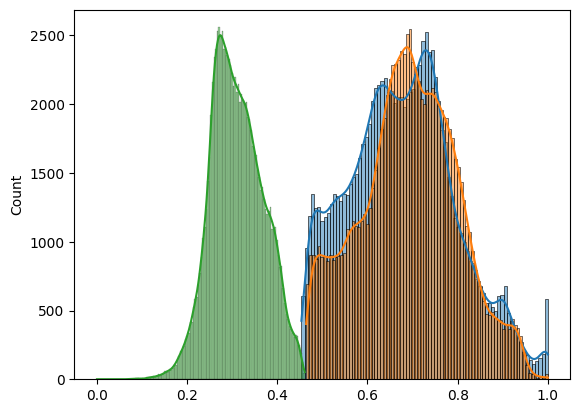

In [24]:
sns.histplot(drugex_a2a, stat="count", kde=True)
sns.histplot(drugex_a1, stat="count", kde=True)
sns.histplot(drugex_herg, stat="count", kde=True)

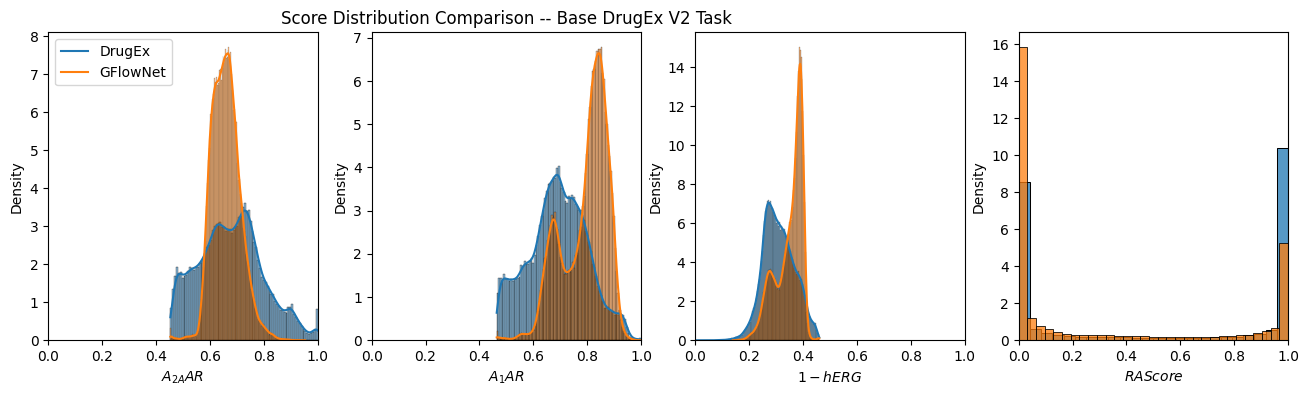

In [108]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
sns.histplot(drugex_a2a, stat="density", kde=True, ax=ax[0])
sns.histplot(gfn_a2a, stat="density", kde=True, ax=ax[0])
ax[0].legend(labels=["DrugEx", "GFlowNet"])
ax[0].set_xlim([0, 1])
ax[0].set_xlabel("$A_{2A}AR$")

sns.histplot(drugex_a1, stat="density", kde=True, ax=ax[1])
sns.histplot(gfn_a1, stat="density", kde=True, ax=ax[1])
ax[1].set_xlim([0, 1])
ax[1].set_xlabel("$A_{1}AR$")

sns.histplot(drugex_herg, stat="density", kde=True, ax=ax[2])
sns.histplot(gfn_herg, stat="density", kde=True, ax=ax[2])
ax[2].set_xlim([0, 1])
ax[2].set_xlabel("$1-hERG$")

# sns.kdeplot(drugex_rascores.flatten(), ax=ax[3])
# sns.kdeplot(gfn_rascores.flatten(), ax=ax[3])
sns.histplot(drugex_rascores.flatten(), stat="density", kde=False, ax=ax[3])
sns.histplot(gfn_rascores.flatten(), stat="density", kde=False, ax=ax[3])
ax[3].set_xlim([0, 1])
ax[3].set_xlabel("$RA Score$")

ax[1].set_title("Score Distribution Comparison -- Base DrugEx V2 Task")
fig.savefig("../reports/score_dist_base_task.png")

In [29]:
gfn_a2a = a2a(gfn_efps)
gfn_a2a = torch.from_numpy(gfn_a2a.astype(np.float32))
gfn_a2a = (gfn_a2a / 8.8).clamp(0, 1)
gfn_a1 = a1(gfn_efps)
gfn_a1 = torch.from_numpy(gfn_a1.astype(np.float32))
gfn_a1 = (gfn_a1 / 8.6).clamp(0, 1)
gfn_herg = herg(gfn_efps)
gfn_herg = torch.from_numpy(gfn_herg.astype(np.float32))
gfn_herg = 1.0 - (gfn_herg / 7.4).clamp(0, 1)
gfn_rascores = ras(gfn_fcfps).detach().numpy()

<AxesSubplot: ylabel='Count'>

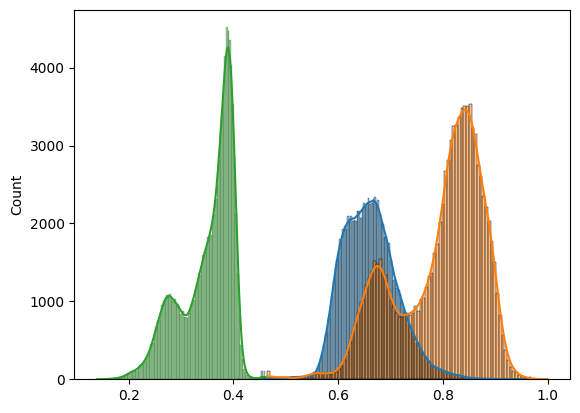

In [30]:
sns.histplot(gfn_a2a, stat="count", kde=True)
sns.histplot(gfn_a1, stat="count", kde=True)
sns.histplot(gfn_herg, stat="count", kde=True)

<AxesSubplot: ylabel='Count'>

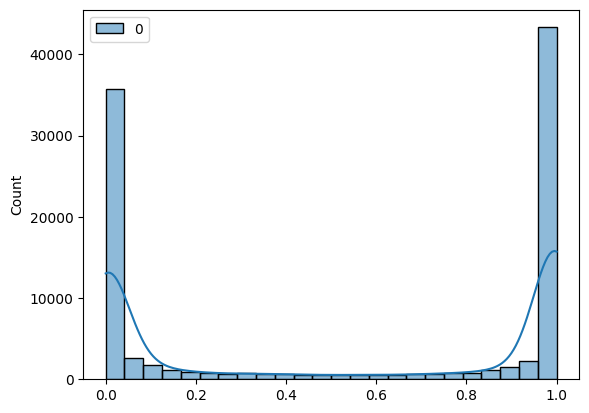

In [34]:
sns.histplot(drugex_rascores, stat="count", kde=True)

<AxesSubplot: ylabel='Count'>

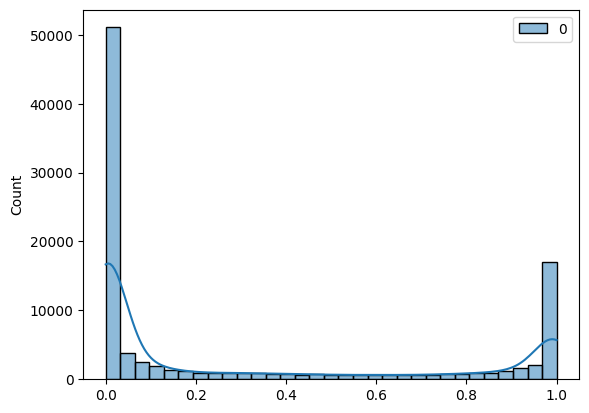

In [35]:
sns.histplot(gfn_rascores, stat="count", kde=True)

In [36]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [42]:
drugex_df = pd.DataFrame({"smiles":drugex_base[0], "A2A":drugex_a2a, "A1":drugex_a1, "hERG":drugex_herg, "RAScore":drugex_rascores.flatten()})
drugex_df.to_csv("../data/temp/drugex_base_100K_smiles_with_scores.csv", index=False)

In [44]:
gfn_df = pd.DataFrame({"smiles":gfn_base[0], "A2A":gfn_a2a, "A1":gfn_a1, "hERG":gfn_herg, "RAScore":gfn_rascores.flatten()})
gfn_df.to_csv("../data/temp/gfn_tb96_base_100K_smiles_with_scores.csv", index=False)

In [47]:
drugex_pf_idx = is_pareto_efficient(-drugex_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float), return_mask=False)
drugex_scores = drugex_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float)
drugex_pf = drugex_scores[drugex_pf_idx]

drugex_df3pf = pd.DataFrame({'x': drugex_pf[:,0], 'y': drugex_pf[:,1], 'z': drugex_pf[:,2]})

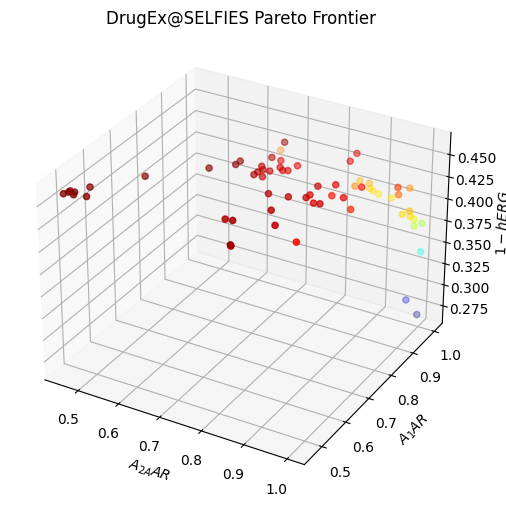

In [109]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(6, 6))
ax.remove()
ax=fig.add_subplot(projection='3d')
ax.scatter3D(drugex_df3pf.x, drugex_df3pf.y, drugex_df3pf.z, c=drugex_df3pf.z, cmap=cm.jet)
ax.set_xlabel("$A_{2A}AR$")
ax.set_ylabel("$A_{1}AR$")
ax.set_zlabel("$1-hERG$")
ax.set_title("DrugEx@SELFIES Pareto Frontier")
fig.savefig("../reports/drugex_base_100K_pf.png")

In [60]:
gfn_pf_idx = is_pareto_efficient(-gfn_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float), return_mask=False)
gfn_scores = gfn_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float)
gfn_pf = gfn_scores[gfn_pf_idx]

gfn_df3pf = pd.DataFrame({'x': gfn_pf[:,0], 'y': gfn_pf[:,1], 'z': gfn_pf[:,2]})

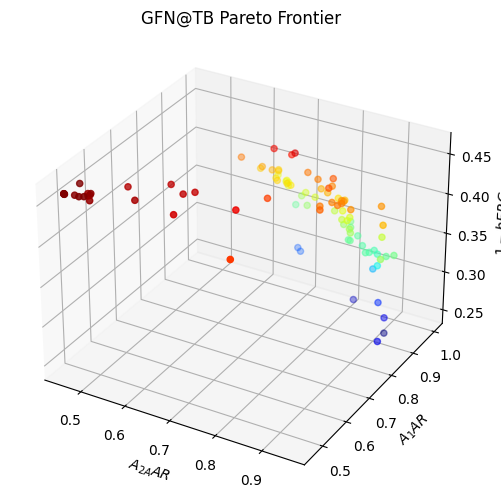

In [111]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(6, 6))
ax.remove()
ax=fig.add_subplot(projection='3d')
ax.scatter3D(gfn_df3pf.x, gfn_df3pf.y, gfn_df3pf.z, c=gfn_df3pf.z, cmap=cm.jet)
ax.set_xlabel("$A_{2A}AR$")
ax.set_ylabel("$A_{1}AR$")
ax.set_zlabel("$1-hERG$")
ax.set_title("GFN@TB Pareto Frontier")
fig.savefig("../reports/gfn_tb96_base_100K_pf.png")

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    fig = None
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    if fig:
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
        cbar.ax.set_ylabel('Density')

    return ax

# Pairplot stuff goes here

In [67]:
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt
from rxitect.scorers.sascore import calculateScore

In [68]:
mols = [Chem.MolFromSmiles(smi) for smi in drugex_base[0]]

In [69]:
sas = [calculateScore(m) for m in mols]
sa_scores = (10 - np.array(sas)) / 9  # transform to [0-1]

In [70]:
qeds = [QED.qed(m) for m in mols]
mws = torch.from_numpy(np.array([MolWt(m) for m in mols]))
sc_mws = (mws / 1000).clip(0, 1)

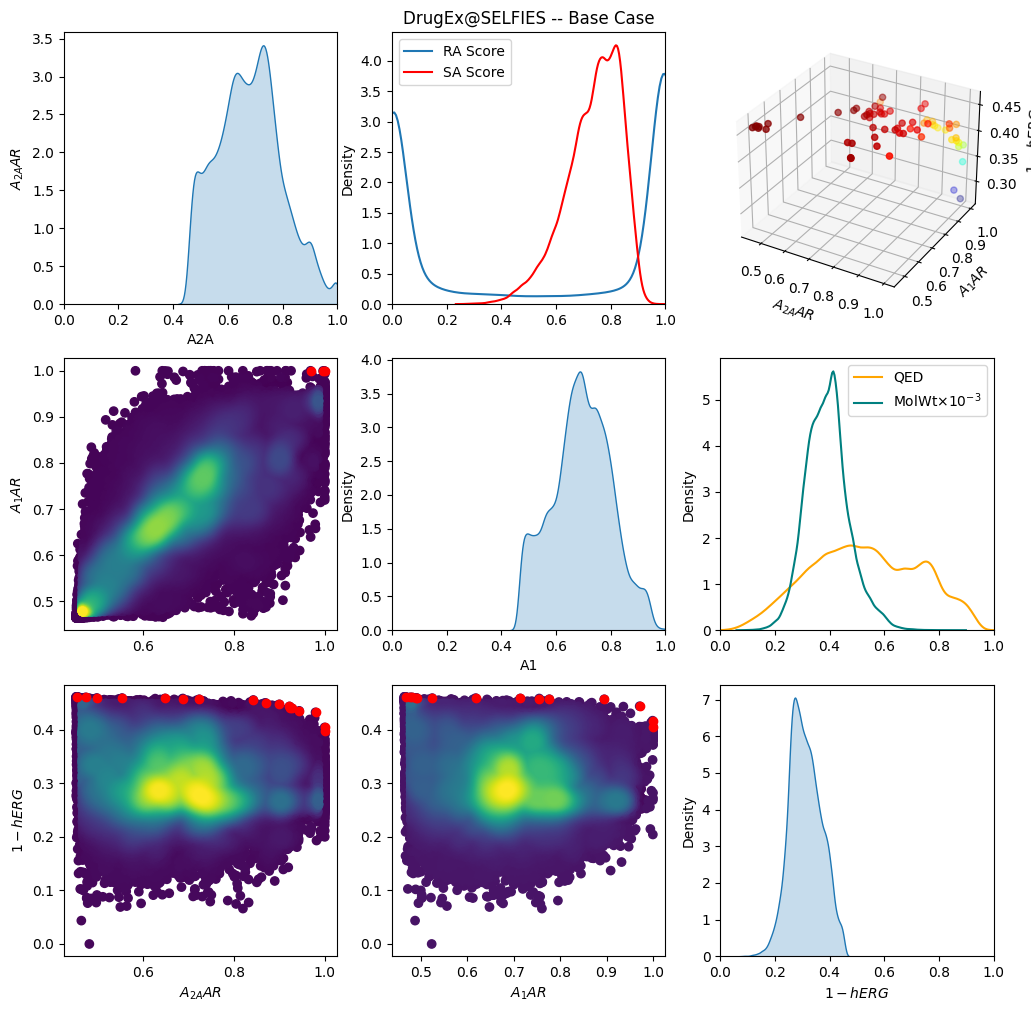

In [77]:
df = drugex_df.copy()
dfx = df[["A2A", "hERG"]]# .to_numpy()[1:].astype(float)
a2a_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A2A", "A1"]]# .to_numpy()[1:].astype(float)
a2a_a1_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A1", "hERG"]]# .to_numpy()[1:].astype(float)
a1_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
# ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
# ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
ax[1, 1].set_xlim([0, 1])
ax[0, 0].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
sns.kdeplot(drugex_rascores, ax=ax[0, 1], color="green")
sns.kdeplot(sa_scores, ax=ax[0, 1], color="red")
ax[0, 1].set_xlim([0, 1])
ax[0, 1].legend(labels=["RA Score", "SA Score"])
sns.kdeplot(qeds, ax=ax[1, 2], color="orange")
sns.kdeplot(sc_mws, ax=ax[1, 2], color="teal")
ax[1, 2].set_xlim([0, 1])
ax[1, 2].legend(labels=["QED", "MolWt$\\times10^{-3}$"])
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[1, 1], color="green")
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[2, 2], color="green")
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(df["A2A"], ax=ax[0, 0], fill=True)
sns.kdeplot(df["A1"], ax=ax[1, 1], fill=True)
sns.kdeplot((df["hERG"]), ax=ax[2, 2], fill=True)
# ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(3,3,3,projection='3d')
ax[0, 2].scatter3D(drugex_df3pf.x, drugex_df3pf.y, drugex_df3pf.z, c=drugex_df3pf.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
# ax[1, 2].axis('off')

ax[0, 1].set_title("DrugEx@SELFIES -- Base Case")
fig.savefig("../reports/drugex_base_100K_pairplot.png")

In [78]:
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt
from rxitect.scorers.sascore import calculateScore

In [79]:
mols = [Chem.MolFromSmiles(smi) for smi in gfn_base[0]]

In [80]:
sas = [calculateScore(m) for m in mols]
sa_scores = (10 - np.array(sas)) / 9  # transform to [0-1]

In [81]:
qeds = [QED.qed(m) for m in mols]
mws = torch.from_numpy(np.array([MolWt(m) for m in mols]))
sc_mws = (mws / 1000).clip(0, 1)

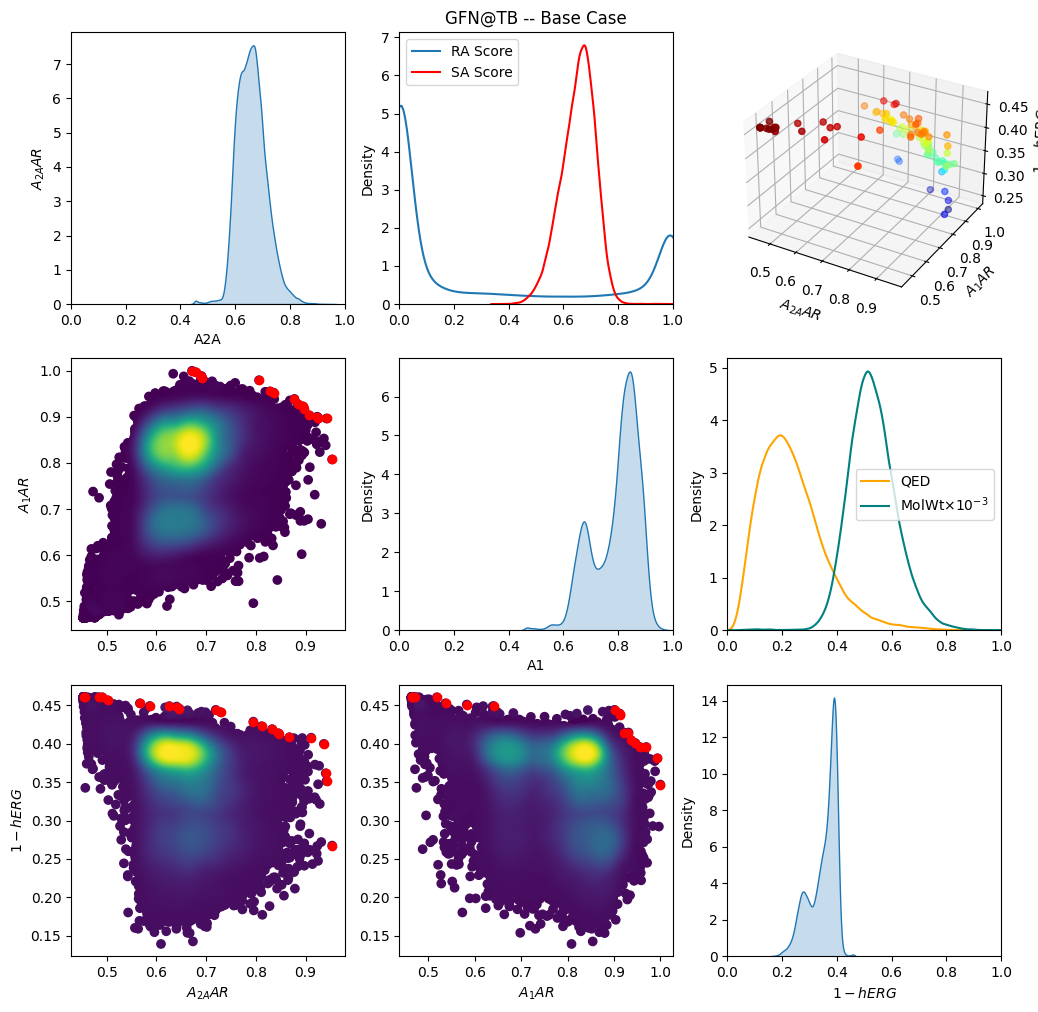

In [82]:
df = gfn_df.copy()
dfx = df[["A2A", "hERG"]]# .to_numpy()[1:].astype(float)
a2a_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A2A", "A1"]]# .to_numpy()[1:].astype(float)
a2a_a1_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A1", "hERG"]]# .to_numpy()[1:].astype(float)
a1_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
# ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
# ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
ax[1, 1].set_xlim([0, 1])
ax[0, 0].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
sns.kdeplot(gfn_rascores, ax=ax[0, 1], color="green")
sns.kdeplot(sa_scores, ax=ax[0, 1], color="red")
ax[0, 1].set_xlim([0, 1])
ax[0, 1].legend(labels=["RA Score", "SA Score"])
sns.kdeplot(qeds, ax=ax[1, 2], color="orange")
sns.kdeplot(sc_mws, ax=ax[1, 2], color="teal")
ax[1, 2].set_xlim([0, 1])
ax[1, 2].legend(labels=["QED", "MolWt$\\times10^{-3}$"])
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[1, 1], color="green")
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[2, 2], color="green")
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(df["A2A"], ax=ax[0, 0], fill=True)
sns.kdeplot(df["A1"], ax=ax[1, 1], fill=True)
sns.kdeplot((df["hERG"]), ax=ax[2, 2], fill=True)
# ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(3,3,3,projection='3d')
ax[0, 2].scatter3D(gfn_df3pf.x, gfn_df3pf.y, gfn_df3pf.z, c=gfn_df3pf.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
# ax[1, 2].axis('off')

ax[0, 1].set_title("GFN@TB -- Base Case")
fig.savefig("../reports/gfn_tb96_base_100K_pairplot.png")